In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

C:\Users\2018\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df= pd.read_csv(r'D:\Semester 9\Data Engineering\M1\ML.csv')

In [3]:
X = df.drop(columns=['total_amount', 'payment_type', 'date_range'])
y = df['total_amount']

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Splitting the temp dataset into validation (20%) and test (20%)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<h1>Decision Trees</h1>

Best Parameters: {'max_depth': 10}


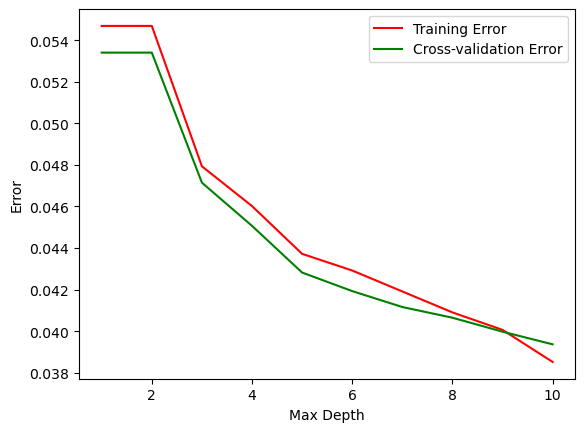

Precision: 0.9601591116615413
Recall: 0.9601591116615413
Best tree depth: 10
Test set error (J_test): 0.019936187407508476
Accuracy: 0.9601591116615413
Confusion Matrix:
[[  427   351     1]
 [    1 82584  1496]
 [    0  1947  8472]]
Micro-average ROC AUC: 0.9945906445982802


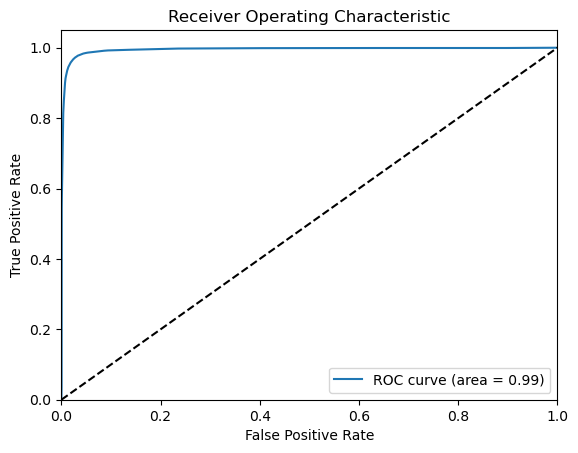

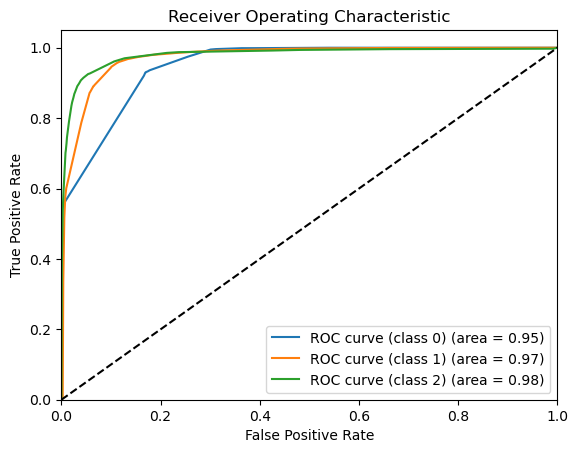

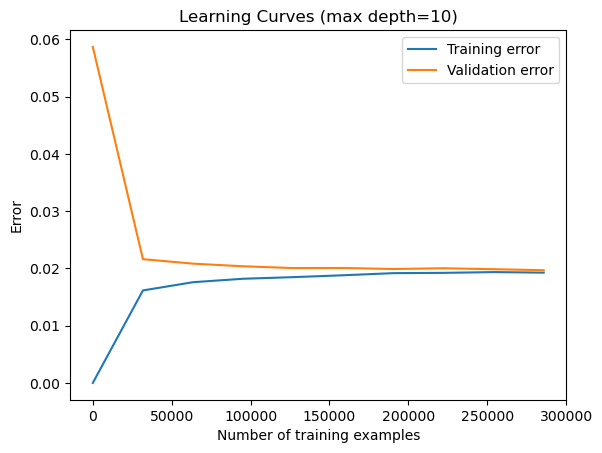

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Assuming X and y are your input features and target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

def model_selection_and_regularization(X_train, y_train, X_cv, y_cv):
    param_grid = {'max_depth': np.arange(1, 11)}
    best_params = {}
    best_score = float('inf')
    train_errors = []
    cv_errors = []

    for max_depth in param_grid['max_depth']:
        clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        clf.fit(X_train, y_train)

        # Calculate training error
        train_error = np.mean((clf.predict(X_train) - y_train) ** 2)
        train_errors.append(train_error)

        # Calculate cross-validation error
        cv_error = np.mean((clf.predict(X_cv) - y_cv) ** 2)
        cv_errors.append(cv_error)

        if cv_error < best_score:
            best_score = cv_error
            best_params = {'max_depth': max_depth}

    return best_params, train_errors, cv_errors

best_params, train_errors, cv_errors = model_selection_and_regularization(X_train, y_train, X_val, y_val)
print(f"Best Parameters: {best_params}")

# Plot training and cross-validation errors
plt.figure()
plt.plot(np.arange(1, 11), train_errors, label="Training Error", color="r")
plt.plot(np.arange(1, 11), cv_errors, label="Cross-validation Error", color="g")
plt.xlabel("Max Depth")
plt.ylabel("Error")
plt.legend()
plt.show()

# Train the final model with the best depth
dt = DecisionTreeClassifier(**best_params, random_state=42)
dt.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = dt.predict(X_test)
test_error = mean_squared_error(y_test, y_pred) / 2
accuracy = accuracy_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate Precision, Recall, and F1-score
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
#f1 = f1_score(y_test, y_pred, average='micro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')



# Binarize the output for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_prob = dt.predict_proba(X_test)

# Calculate micro-average ROC AUC
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='micro')

print(f'Best tree depth: {best_params["max_depth"]}')
print(f'Test set error (J_test): {test_error}')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print(f'Micro-average ROC AUC: {roc_auc}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Plot ROC Curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Learning Curves
def plot_learning_curves(X_train, y_train, X_val, y_val, max_depth):
    train_errors, val_errors = [], []
    m_values = np.linspace(1, len(X_train), 10, dtype=int)

    for m in m_values:
        dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        dt.fit(X_train[:m], y_train[:m])

        y_train_predict = dt.predict(X_train[:m])
        y_val_predict = dt.predict(X_val)

        train_errors.append(mean_squared_error(y_train[:m], y_train_predict) / 2)
        val_errors.append(mean_squared_error(y_val, y_val_predict) / 2)

    plt.plot(m_values, train_errors, label="Training error")
    plt.plot(m_values, val_errors, label="Validation error")
    plt.xlabel("Number of training examples")
    plt.ylabel("Error")
    plt.title(f"Learning Curves (max depth={max_depth})")
    plt.legend()
    plt.show()

plot_learning_curves(X_train, y_train, X_val, y_val, max_depth=best_params["max_depth"])


**The first graph helps us identify the optimal max_depth**

**Good Fit: The close proximity of the training and cross-validation errors in the learning curvesuggests that the model is generalizing well to unseen data.** 

**Good Performance: The model is performing very well with high accuracy, precision, recall, and AUC values.**

**Low Misclassifications: The confusion matrix shows low false positives and false negatives, confirming the high-performance metrics.**

**For multi-class classification, the ROC curve can be calculated using several strategies, one of which is the "one-vs-all" approach, where each class is treated as the positive class in turn, and the rest as the negative class. This results in multiple ROC curves, one for each class. The micro-average of the ROC curve aggregates the TPRs and FPRs across all classes to calculate a single ROC curve, which represents the overall performance of the classifier across all classes.**

**Binarization is the process of converting multi-class labels into binary labels. In the context of ROC curve calculation, binarization is necessary because the ROC curve is typically used for binary classification. Binarization is done by considering one class as the positive class and all other classes as the negative class. The binarize step converts the multi-class labels into binary labels for calculating the ROC curve.**

**High Accuracy.**

#
<h1>Decision Trees with stratified sampling & gain/gini ratio</h1>

Best Parameters: {'max_depth': 10}


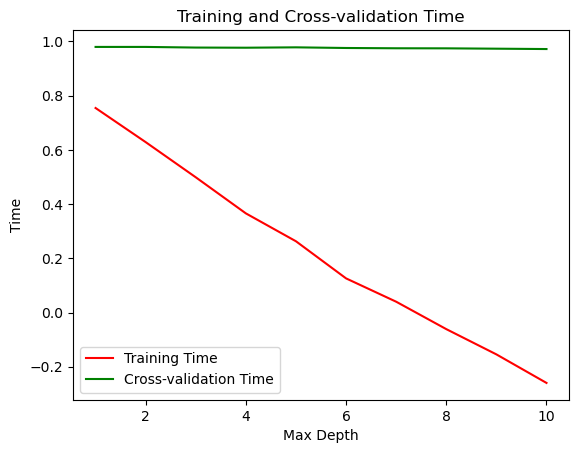

Test Accuracy: 0.96
Precision: 0.96
Recall: 0.96
Confusion Matrix:
[[  446   364     1]
 [    1 82468  1638]
 [    0  1890  8471]]


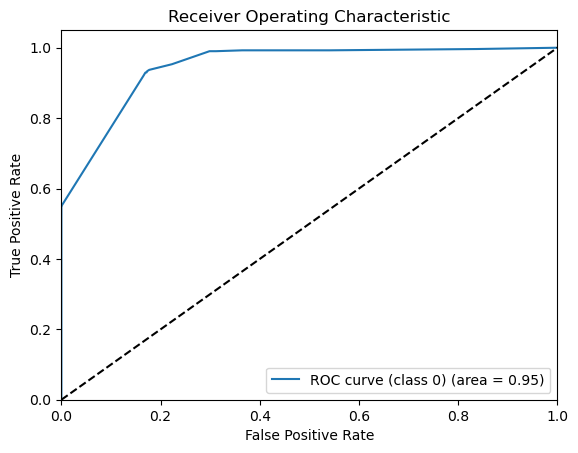

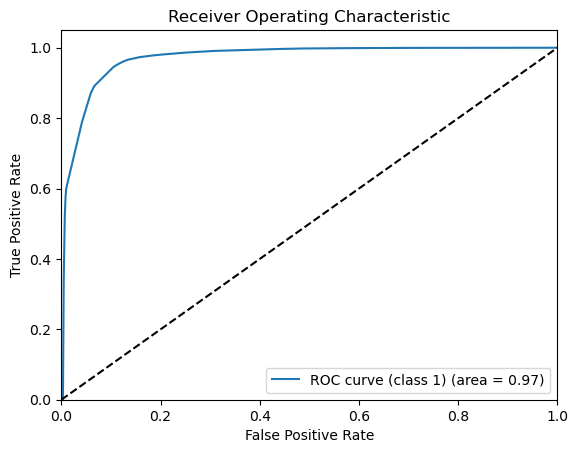

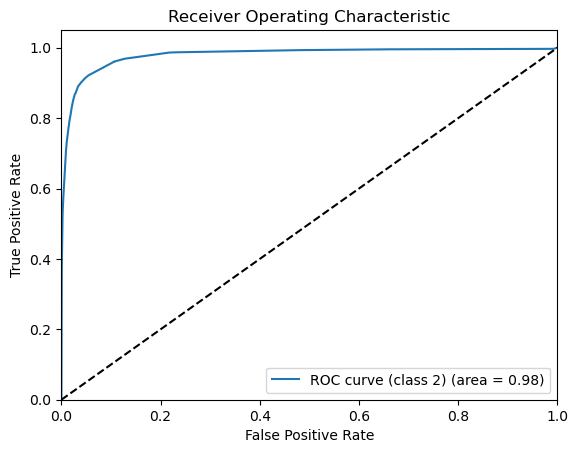

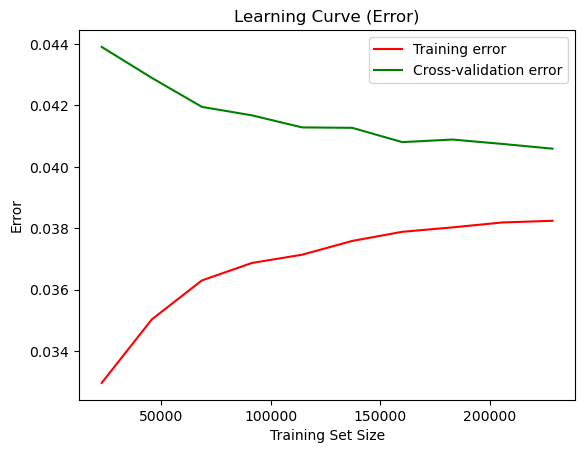

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

# Split the data into training and temp (40%) datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Splitting the temp dataset into validation (20%) and test (20%)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# K-fold cross-validation function
def kfold_cross_validation(X, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    param_grid = {'max_depth': np.arange(1, 11)}
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=skf, scoring='accuracy')
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.cv_results_

best_params, cv_results = kfold_cross_validation(X_train, y_train)
print(f"Best Parameters: {best_params}")

# Extracting training and cross-validation errors from cv_results_
train_errors = 1 - cv_results['mean_fit_time']
cv_errors = 1 - cv_results['mean_score_time']
max_depth_range = np.arange(1, 11)

# Plot training and cross-validation errors
plt.figure()
plt.plot(max_depth_range, train_errors, label="Training Time", color="r")
plt.plot(max_depth_range, cv_errors, label="Cross-validation Time", color="g")
plt.xlabel("Max Depth")
plt.ylabel("Time")
plt.legend()
plt.title("Training and Cross-validation Time")
plt.show()

# Train the final model with the best parameters
clf = DecisionTreeClassifier(**best_params, criterion='gini', random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, clf.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Learning curve
train_sizes, train_scores, cv_scores = learning_curve(clf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculate mean training and cross-validation scores
train_mean = np.mean(train_scores, axis=1)
cv_mean = np.mean(cv_scores, axis=1)

# Calculate error as (1 - accuracy)
train_error = 1 - train_mean
cv_error = 1 - cv_mean

# Plotting learning curve
plt.figure()
plt.plot(train_sizes, train_error, label="Training error", color="r")
plt.plot(train_sizes, cv_error, label="Cross-validation error", color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Error")
plt.legend(loc="best")
plt.title("Learning Curve (Error)")
plt.show()


**Overfittinggggggggggggggggggggggggggggggggggggg.**

<h1>Random Forest</h1>

Precision: 0.9590885714585585
Recall: 0.9590885714585585
Test set error (J_test): 0.020455714270720727
Accuracy: 0.9590885714585585
Confusion Matrix:
[[  422   357     0]
 [    1 82601  1479]
 [    0  2061  8358]]
Micro-average ROC AUC: 0.9949317104762745


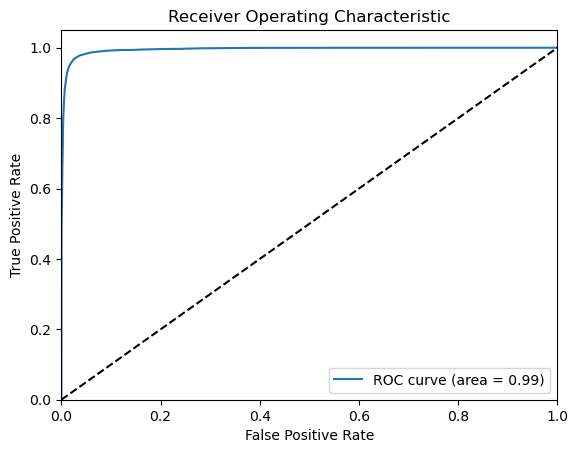

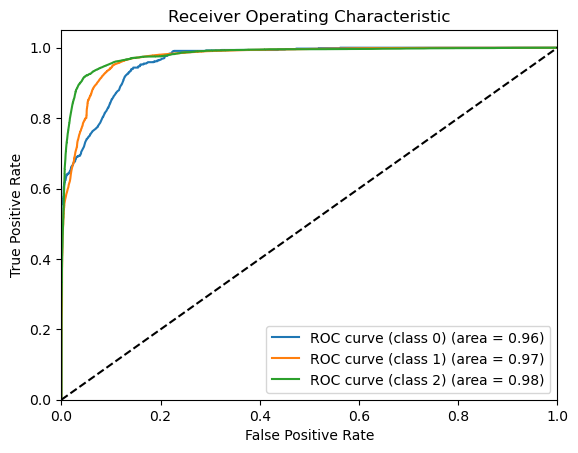

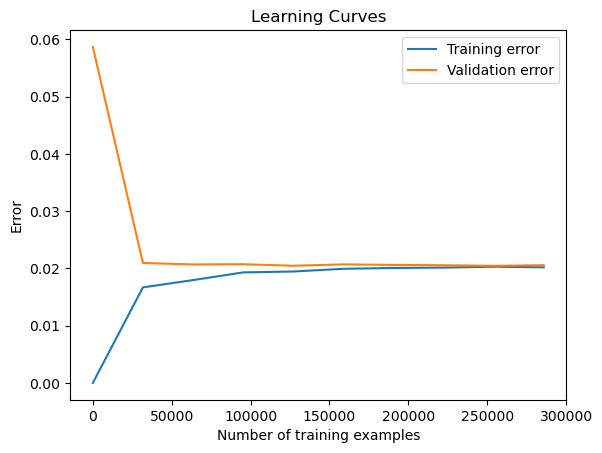

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score


import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import time


# Assuming X and y are your input features and target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test


# Train the final model with the best parameters
#rf = RandomForestClassifier(**best_params, random_state=42)
rf = RandomForestClassifier(max_depth=10,random_state=42)

rf.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = rf.predict(X_test)
test_error = mean_squared_error(y_test, y_pred) / 2
accuracy = accuracy_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate Precision, Recall, and F1-score
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Binarize the output for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_prob = rf.predict_proba(X_test)

# Calculate micro-average ROC AUC
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='micro')

print(f'Test set error (J_test): {test_error}')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print(f'Micro-average ROC AUC: {roc_auc}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot ROC Curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Learning Curves
def plot_learning_curves(X_train, y_train, X_val, y_val):
    train_errors, val_errors = [], []
    m_values = np.linspace(1, len(X_train), 10, dtype=int)

    for m in m_values:
        rf = RandomForestClassifier(max_depth=10,random_state=42)
        rf.fit(X_train[:m], y_train[:m])

        y_train_predict = rf.predict(X_train[:m])
        y_val_predict = rf.predict(X_val)

        train_errors.append(mean_squared_error(y_train[:m], y_train_predict) / 2)
        val_errors.append(mean_squared_error(y_val, y_val_predict) / 2)

    plt.plot(m_values, train_errors, label="Training error")
    plt.plot(m_values, val_errors, label="Validation error")
    plt.xlabel("Number of training examples")
    plt.ylabel("Error")
    plt.title("Learning Curves")
    plt.legend()
    plt.show()

plot_learning_curves(X_train, y_train, X_val, y_val)


**Good fit: Plateau in the learning curve.**

**Good ROC Values: Diagonal values are the largest.**


**Good ROC Curve and high accuracy.**